<a href="https://colab.research.google.com/github/AhmetDemiroglu/Simon/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install pillow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import json
import os
import shutil
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

# JSON verilerini yükle
with open('/content/drive/MyDrive/setid.json') as f:
    set_ids = json.load(f)

with open('/content/drive/MyDrive/imagelabels.json') as f:
    labels = json.load(f)['labels']

# Klasör yapılarını oluştur
base_dir = '/content/oxford_flowers102'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Klasörleri oluştur
for dir_path in [train_dir, val_dir, test_dir]:
    for i in range(1, 103):  # 102 sınıf var
        os.makedirs(os.path.join(dir_path, str(i)), exist_ok=True)

# Görüntüleri kontrol etme ve taşıma işlemini paralel hale getirme
def process_image(idx, label):
    file_name = f'image_{idx:05d}.jpg'
    src_file_path = os.path.join('/content/drive/MyDrive/images', file_name)
    try:
        # Görüntü dosyasını açmayı deneyin
        with Image.open(src_file_path) as img:
            img.verify()  # Görüntünün bozuk olup olmadığını kontrol edin
        # Görüntü dosyasını doğru klasöre taşıyın
        if idx in set_ids['trnid']:
            dest_dir = train_dir
        elif idx in set_ids['valid']:
            dest_dir = val_dir
        else:
            dest_dir = test_dir
        dest_file_path = os.path.join(dest_dir, str(label), file_name)
        shutil.copy(src_file_path, dest_file_path)
    except (IOError, SyntaxError) as e:
        print(f'Bozuk dosya atlandı: {src_file_path}')

# Paralel işlem yürütme
with ThreadPoolExecutor(max_workers=8) as executor:
    executor.map(lambda x: process_image(x[0], x[1]), enumerate(labels, 1))

print("Veri seti başarıyla hazırlandı ve bozuk dosyalar atlandı.")

Veri seti başarıyla hazırlandı ve bozuk dosyalar atlandı.


Num GPUs Available:  1
Found 1020 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.
Found 6149 images belonging to 102 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/50
32/32 [==============================] - 39s 646ms/step - loss: 4.5849 - accuracy: 0.0431 - val_loss: 4.1554 - val_accuracy: 0.1245 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 19s 614ms/step - loss: 3.8198 - accuracy: 0.2480 - val_loss: 3.4604 - val_accuracy: 0.2873 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 17s 539ms/step - loss: 3.0343 - accuracy: 0.4216 - val_loss: 2.6891 - val_accuracy: 0.4735 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 17s 539ms/step - loss: 2.2931 - accuracy: 0.5627 - val_loss: 2.1234 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 19s 598ms/step - loss: 1.6461 - accuracy: 0.7137 - val_loss: 1.7008 - val_accuracy: 0.67

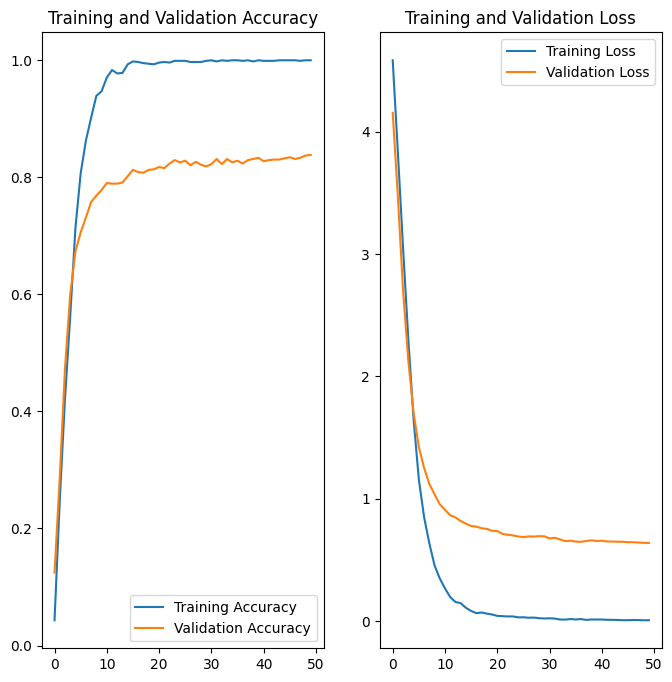

193/193 [==============================] - 23s 117ms/step - loss: 0.7404 - accuracy: 0.8105

Test doğruluğu: 0.8105382919311523


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Google Colab'da GPU kullanımı
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Veri seti ön işleme ve artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/oxford_flowers102/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    '/content/oxford_flowers102/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '/content/oxford_flowers102/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Model oluşturma (InceptionV3 kullanarak)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Transfer öğrenme için temel modelin bazı katmanlarını eğitime aç

# Temel modelin sadece son birkaç katmanını eğitime aç
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(102, activation='softmax')
])

# Modeli derleme
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Erken durdurma ve öğrenme oranı azaltıcı
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=50,  # Daha fazla epoch ile eğitmek
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Eğitim sürecini görselleştirme
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Modeli değerlendirme
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest doğruluğu: {test_acc}')